In [1]:
import numpy as np
np.set_printoptions(precision=7)
np.set_printoptions(suppress=True)
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
file_path = 'data.csv'
df = pd.read_csv(file_path)

In [3]:
# preprocessing: separating the IDs and numerical values
customer_id = df[['CUST_ID']].copy()
df = df[df.columns[~df.columns.isin(['CUST_ID'])]]

In [4]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
df.fillna(df.median(), inplace=True)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# A. Data exploration: Histograms

In [6]:
def plot_hist_feature(data, title, number=None, nbins=50):
    plt.figure(figsize=(7, 4))
    plt.hist(data, nbins)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"Histogram {number} - {title}", fontsize=17)
    
    plt.show()

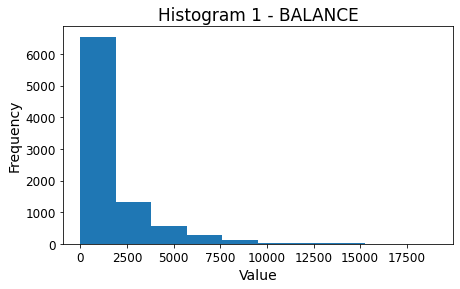

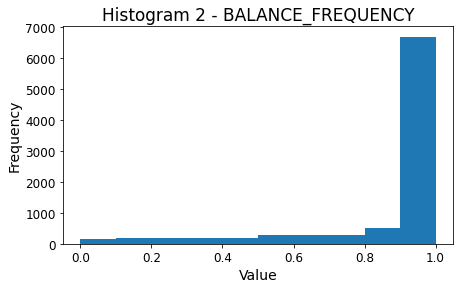

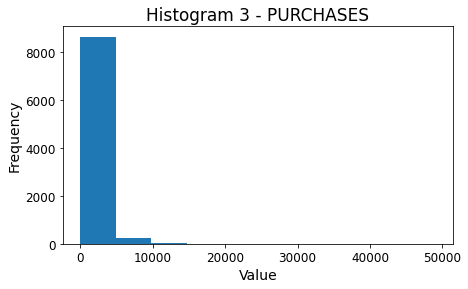

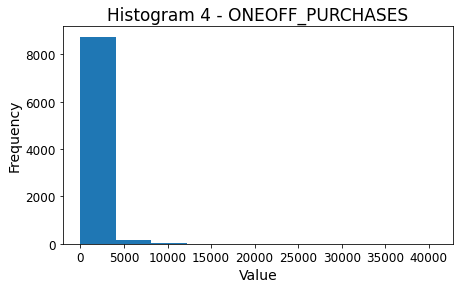

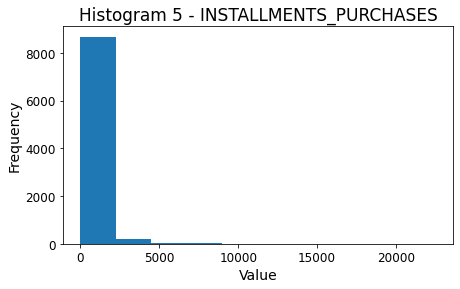

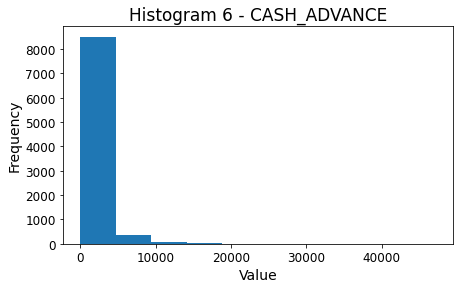

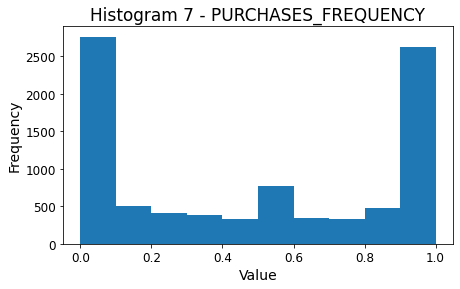

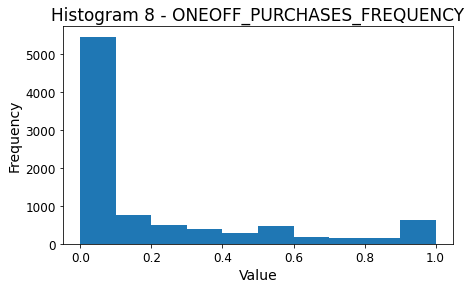

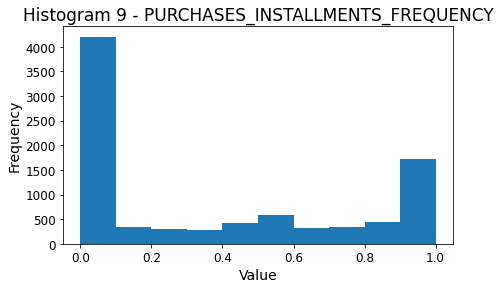

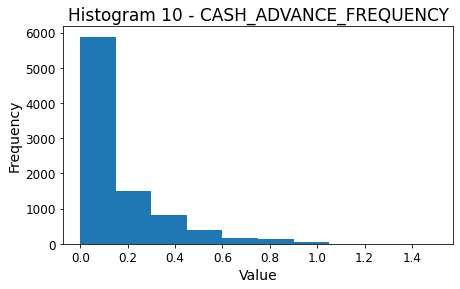

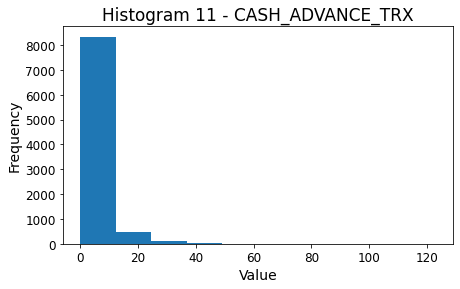

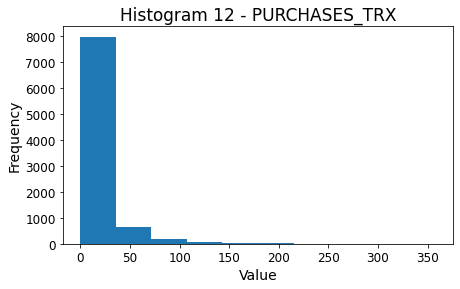

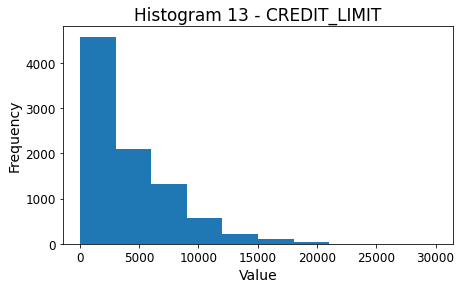

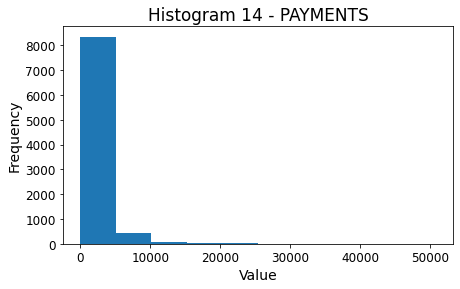

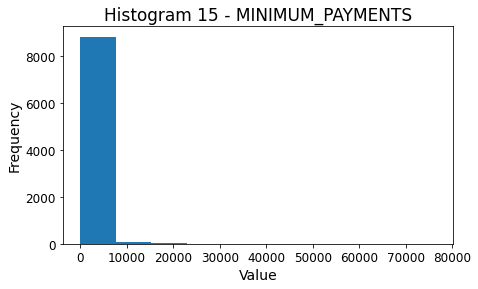

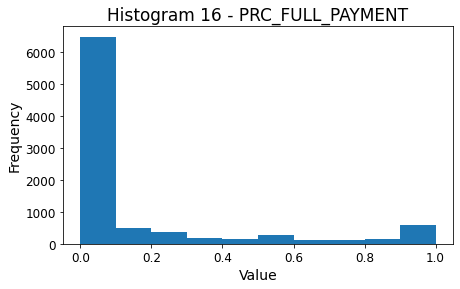

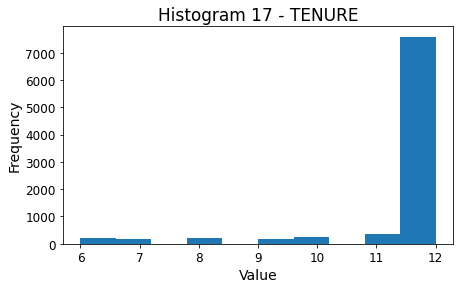

In [7]:
for i, feature in enumerate(df.columns):
    plot_hist_feature(df[feature], feature, i+1, nbins=None)

Data is highly skew, so the median imputation makes sense and preserves the mean well

# B. Data exploration: Feature's correlation

In [8]:
def get_pearson_coeff(dataframe, feature1, feature2):
    '''
    Given 2 feature names return the Pearson’s correlation coefficient between them
    '''
    ### YOUR CODE HERE
    x = dataframe[feature1]
    y = dataframe[feature2]
    return stats.pearsonr(x, y)[0]

In [9]:
corrs = np.zeros((17, 17))
correlations = []

for i, feature1 in enumerate(df.columns):
    for j, feature2 in enumerate(df.columns):
        if i > j:
            continue
        corr = get_pearson_coeff(df, feature1, feature2)
        corrs[i, j] = corr
        corrs[j, i] = corr
        correlations.append([feature1, feature2, corr])
        
correlations = pd.DataFrame(data=correlations, columns=['feature1', 'feature2', 'value'])

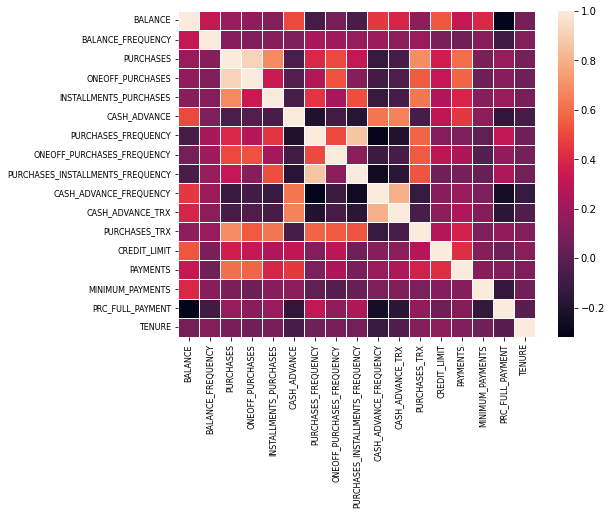

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(corrs, linewidths=.5)
plt.xticks(np.arange(17)+0.5, df.columns, rotation=90, fontsize=8)
plt.yticks(np.arange(17)+0.5, df.columns, rotation=0,fontsize=8)
plt.show()

In [11]:
correlations[(correlations.value.abs() > 0.6) & (correlations.feature1 != correlations.feature2)]

,feature1,feature2,value
34,PURCHASES,ONEOFF_PURCHASES,0.916845
35,PURCHASES,INSTALLMENTS_PURCHASES,0.679896
42,PURCHASES,PURCHASES_TRX,0.689561
44,PURCHASES,PAYMENTS,0.603264
69,INSTALLMENTS_PURCHASES,PURCHASES_TRX,0.628108
79,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,0.628522
80,CASH_ADVANCE,CASH_ADVANCE_TRX,0.656498
89,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.862934
118,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.799561


The correlation does not tell much information about the dataset. i.e. the highest
corrleation shows only dependency between purchases and oneoff_purchases that makes
sense. Therefore, we choose to use a threshold of 0.7

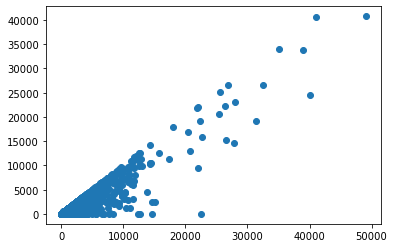

In [12]:
plt.figure()
plt.scatter(df.PURCHASES, df.ONEOFF_PURCHASES)
plt.show()

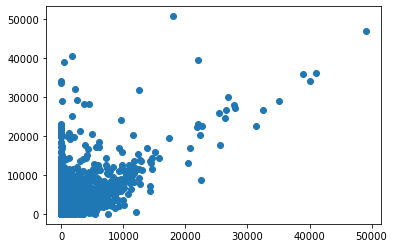

In [13]:
plt.figure()
plt.scatter(df.PURCHASES, df.PAYMENTS)
plt.show()

# C. K-means clustering: Find optimal K using feature 2-16

In [14]:
def calculate_optimal_k(inertias, threshold=0.1):
    for i, inertia in enumerate(inertias):
        if i == len(inertias) - 2:
            print(f'No optimal K has been found using {threshold}')
            break

        slope = inertias[i+1] - inertia
        next_slope = inertias[i+2] - inertias[i+1]
        # variation = 100 * abs((next_slope - slope) / slope)
        variation = next_slope / slope
        print(variation)
        if variation < 1 + threshold and variation> 1 - threshold:
            return i+1

        # if variation < threshold:
        #     return i+1

In [15]:
def plot_elbow_method(inertias, optimal_number):
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(inertias)+1), inertias, 'bo--')
    plt.axvline(x=optimal_number, linestyle='dashed', c='red')
    plt.title('Elbow method', fontsize=17)
    plt.xlabel('Number of clusters K', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0, len(inertias)+1])
    plt.grid()
    plt.show()

In [16]:
# First, we normalize the dataset to 0 mean and 1 standard deviation

sc = StandardScaler()
X = sc.fit_transform(df[df.columns[0:15]])

In [17]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [18]:
k_optimal = calculate_optimal_k(inertias, threshold=0.15)
k_optimal

0.6836740625811462
0.7836388227047284
0.5935017076501884
0.8431228951759077
0.821466095709314
0.6660224799909811
1.3104214832853598
0.5747743230948128
0.8925365471763269


9

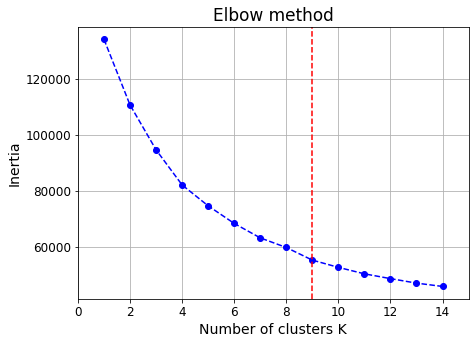

In [19]:
plot_elbow_method(inertias, k_optimal)

The elbow method using features 2-16 does not show a clear optimal K. It looks like
an smooth curve instead. Nvertheless, the optimial K* in this case is 9

In [20]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=0, init='k-means++')
kmeans.fit(X)
df['label'] = kmeans.labels_

In [21]:
# number of users on each clusters
values, counts = np.unique(kmeans.labels_, return_counts=True)

heading = '{:9s} {}'.format('cluster', '#users')
print(heading)
print('-' * len(heading))

for value, count in zip(values, counts):
    print('{:7} {:8.0f}'.format(value, count))

cluster   #users
----------------
      0       30
      1     1289
      2     2197
      3      184
      4     1177
      5       36
      6     1086
      7      435
      8     2516


In [22]:
# centroid of each cluster

cluster_id = pd.DataFrame(data=np.arange(k_optimal), columns=['cluster_id'])
centroids = pd.DataFrame(data=kmeans.cluster_centers_, columns=df.columns[0:15])
centroids = pd.concat((cluster_id, centroids), axis=1)
centroids

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,0,1.923051,0.337717,11.212042,10.600367,7.033118,0.419625,1.046983,1.915501,0.981334,-0.258912,0.061229,5.362438,3.044081,8.098975,1.127533
1,1,-0.696008,-2.141823,-0.314337,-0.234929,-0.311540,-0.309238,-0.571962,-0.443026,-0.459127,-0.484842,-0.362135,-0.427814,-0.209005,-0.217401,-0.284810
2,2,-0.389290,0.312611,-0.062497,-0.253874,0.318589,-0.361613,0.971081,-0.410666,1.166088,-0.463306,-0.358948,0.137330,-0.315118,-0.244699,-0.097782
3,3,1.798371,0.335380,0.028045,0.035554,0.000670,4.095958,-0.177684,0.077097,-0.138124,2.562457,3.790992,0.032008,1.333289,2.768019,0.543529
4,4,-0.141814,0.382661,0.415756,0.551677,-0.030588,-0.324833,0.909387,1.812772,0.079217,-0.384988,-0.311481,0.489630,0.346766,0.062041,-0.151561
5,5,1.290312,0.454124,-0.039755,-0.268864,0.399233,-0.000938,0.022469,-0.528409,0.262206,-0.252602,-0.060885,0.219536,-0.004918,-0.129901,11.639130
6,6,1.304045,0.378916,-0.318058,-0.230129,-0.329294,1.183025,-0.670428,-0.350507,-0.574911,1.566224,1.170368,-0.403679,0.689540,0.192704,0.284949
7,7,0.842822,0.465896,2.263989,1.783132,2.077318,-0.193684,1.161611,1.625388,1.206602,-0.305925,-0.211968,2.737785,1.238143,1.251780,0.278662
8,8,-0.118420,0.367155,-0.368214,-0.250147,-0.410959,-0.155473,-0.891739,-0.413088,-0.786021,0.029419,-0.100845,-0.498344,-0.425493,-0.300747,-0.088627


In [31]:
# scatter average distance to each cluster

data = []
for i in range(k_optimal):
    center = kmeans.cluster_centers_[i]
    instances = X[kmeans.labels_ == i]
    n_instances, _ = instances.shape
    centers = np.repeat(center.reshape(1, 15), n_instances, axis=0)
    
    distances2 = np.power(instances - centers, 2).sum(axis=1)
    distances = np.power(distances2, 0.5)
    
    data.append([i, distances.mean(), np.median(distances), distances.min(), distances.max()])
    
scatters = pd.DataFrame(data=data, columns=['cluster_id', 'mean_dist', 'median_dist', 'min_dist', 'max_dist'])
scatters

,cluster_id,mean_dist,median_dist,min_dist,max_dist
0,0,11.105302,10.624320,3.402662,22.405988
1,1,1.685091,1.474170,0.457634,10.122187
2,2,1.643020,1.416073,0.631877,5.810529
3,3,5.191786,4.581835,2.026968,25.171336
4,4,2.246954,2.102894,0.855242,5.525345
5,5,5.593955,4.890549,1.640651,22.704802
6,6,2.730906,2.567430,0.993428,7.408275
7,7,4.151028,3.554662,1.128422,13.164159
8,8,1.435867,1.319770,0.467626,5.637960


## Discussion

In [36]:
df.groupby(by=['label']).aggregate({'min', 'mean', 'std'}).T

label                                             0            1            2  \
BALANCE                          min    1268.809031     0.000000     0.734665   
                                 std    4317.023492   242.544020  1039.154084   
                                 mean   5567.142164   115.631634   754.200048   
BALANCE_FREQUENCY                min       0.272727     0.000000     0.272727   
                                 std       0.142828     0.192860     0.110051   
                                 mean      0.957273     0.369792     0.951325   
PURCHASES                        min   11500.940000     0.000000    12.000000   
                                 std    9110.260917   479.406732   740.675738   
                                 mean  24957.905000   331.876393   869.679094   
ONEOFF_PURCHASES                 min       0.000000     0.000000     0.000000   
                                 std   10930.579430   445.304178   347.715711   
                                 mean  18186.875667   202.659992   171.058111   
INSTALLMENTS_PURCHASES           min       0.000000     0.000000    12.000000   
                                 std    5740.935137   243.378461   606.640011   
                                 mean   6771.029333   129.446656   699.164124   
CASH_ADVANCE                     min       0.000000     0.000000     0.000000   
                                 std    5063.164142   824.638824   638.718244   
                                 mean   1858.844605   329.742924   220.552694   
PURCHASES_FREQUENCY              min       0.166667     0.000000     0.416667   
                                 std       0.216578     0.248409     0.154266   
                                 mean      0.910556     0.260997     0.880092   
ONEOFF_PURCHASES_FREQUENCY       min       0.000000     0.000000     0.000000   
                                 std       0.312531     0.110711     0.124699   
                                 mean      0.773889     0.070349     0.079948   
PURCHASES_INSTALLMENTS_FREQUENCY min       0.000000     0.000000     0.250000   
                                 std       0.353308     0.251888     0.183925   
                                 mean      0.754444     0.182110     0.827871   
CASH_ADVANCE_FREQUENCY           min       0.000000     0.000000     0.000000   
                                 std       0.228480     0.074269     0.099758   
                                 mean      0.083333     0.037764     0.042432   
CASH_ADVANCE_TRX                 min       0.000000     0.000000     0.000000   
                                 std      10.999478     1.968629     2.022920   
                                 mean      3.666667     0.768037     0.799272   
PURCHASES_TRX                    min       3.000000     0.000000     0.000000   
                                 std     101.634572     4.470741    12.780827   
                                 mean    148.000000     4.079131    18.123350   
CREDIT_LIMIT                     min    3000.000000   300.000000   400.000000   
                                 std    5730.929394  3177.937785  2706.491869   
                                 mean  15570.000000  3734.786225  3347.741640   
PAYMENTS                         min    8760.860264     0.000000     0.000000   
                                 std    9983.918614  2353.893111  1019.209870   
                                 mean  25178.882690  1104.646257  1024.762894   
MINIMUM_PAYMENTS                 min     310.712671     0.019163     0.261984   
                                 std    4977.719458   195.909100  1258.201694   
                                 mean   3475.059479   180.439728   616.815358   
PRC_FULL_PAYMENT                 min       0.000000     0.000000     0.000000   
                                 std       0.417721     0.349129     0.341773   
                                 mean      0.478409     0.229720     0.250595   
TENURE                         

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='randomized', random_state=42)
pca.fit(X)
pca_x = pca.transform(X)

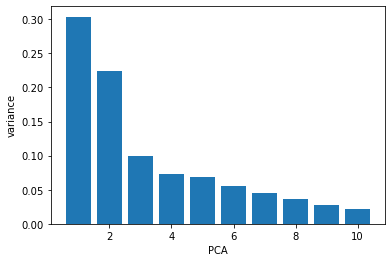

In [12]:
plt.figure()
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.xlabel("PCA")
plt.ylabel("variance")
plt.show()

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', n_iter=1000, n_iter_without_progress=50, verbose=0)
tsne_x = tsne.fit_transform(X)

C:\Users\Cristhian\software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [14]:
from umap import UMAP

umap = UMAP(n_components=3, n_neighbors=10, min_dist=0.05)
umap_x = umap.fit_transform(X)

In [46]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(k, kmeans.n_iter_)

1 2
2 8
3 25
4 27
5 19
6 80
7 52
8 67
9 40
10 28
11 22
12 49
13 75
14 45


In [47]:
k_optimal = calculate_optimal_k(inertias, threshold=0.15)
k_optimal

0.6836740625811462
0.7836388227047284
0.5935017076501884
0.8431228951759057
0.8214660957093182
0.6660224799909793
1.3104214832853578
0.5747743230948154
0.8925365471763244


9

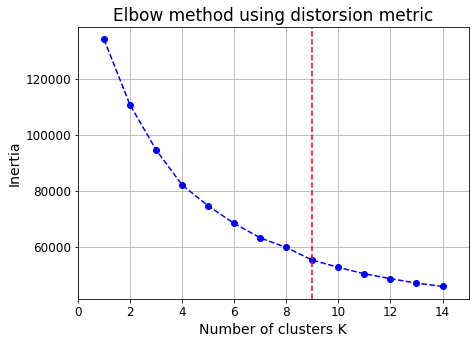

In [48]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 15), inertias, 'bo--')
plt.axvline(x=k_optimal, linestyle='dashed', c='red')
plt.title('Elbow method using distorsion metric', fontsize=17)
plt.xlabel('Number of clusters K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 15])
plt.grid()
plt.show()

In [49]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=0, init='random')
kmeans.fit(X)
df['label'] = kmeans.labels_

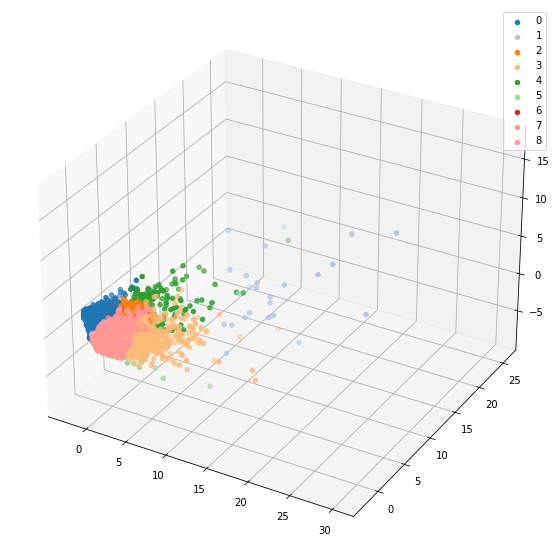

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = [plt.cm.tab20(0), plt.cm.tab20(1), plt.cm.tab20(2), plt.cm.tab20(3), plt.cm.tab20(4), plt.cm.tab20(5), plt.cm.tab20(6), plt.cm.tab20(7), plt.cm.tab20(7)]

for k in range(k_optimal):
    mask = kmeans.labels_ == k
    ax.scatter(pca_x[mask][:,0], pca_x[mask][:,1], pca_x[mask][:,2], color=colors[k], label=str(k))
    
plt.legend()
plt.show()

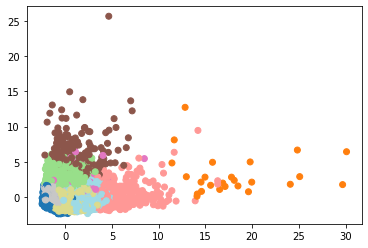

In [51]:
plt.figure()
plt.scatter(pca_x[:,0], pca_x[:,1], c=kmeans.labels_, cmap=plt.cm.tab20)
plt.show()

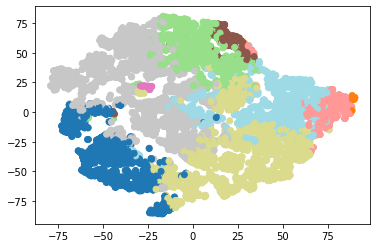

In [52]:
plt.figure()
plt.scatter(tsne_x[:,0], tsne_x[:,1], c=kmeans.labels_, cmap=plt.cm.tab20)
plt.show()

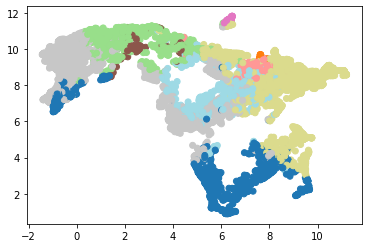

In [57]:
plt.figure()
plt.scatter(umap_x[:,0], umap_x[:,1], c=kmeans.labels_, cmap=plt.cm.tab20)
plt.show()

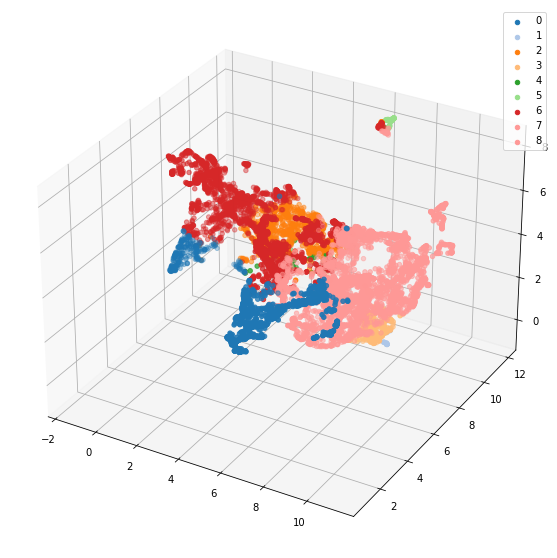

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = [plt.cm.tab20(0), plt.cm.tab20(1), plt.cm.tab20(2), plt.cm.tab20(3), plt.cm.tab20(4), plt.cm.tab20(5), plt.cm.tab20(6), plt.cm.tab20(7), plt.cm.tab20(7)]

for k in range(9):
    mask = kmeans.labels_ == k
    ax.scatter(umap_x[mask][:,0], umap_x[mask][:,1], umap_x[mask][:,2], color=colors[k], label=str(k))
    
plt.legend()
plt.show()

In [58]:
inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++')
    kmeans.fit(umap_x)
    inertias.append(kmeans.inertia_)
    print(k, kmeans.n_iter_)

1 2
2 4
3 6
4 12
5 13
6 6
7 25
8 7
9 16
10 7
11 9
12 13
13 14
14 9


In [59]:
k_optimal = calculate_optimal_k(inertias, threshold=0.02)
k_optimal

0.30676363460194467
0.3953770913638357
0.7882327018698598
0.9801342058226544


4

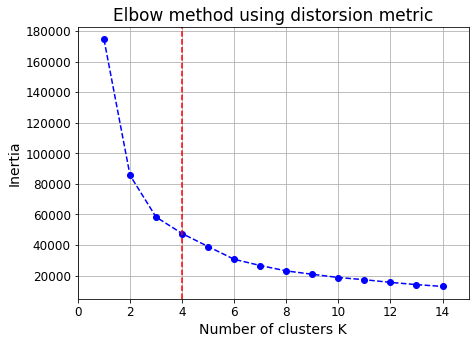

In [60]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 15), inertias, 'bo--')
plt.axvline(x=k_optimal, linestyle='dashed', c='red')
plt.title('Elbow method using distorsion metric', fontsize=17)
plt.xlabel('Number of clusters K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 15])
plt.grid()
plt.show()

In [61]:
# 11 cluster, but looks so many
kmeans = KMeans(n_clusters=k_optimal, random_state=0, init='random')
kmeans.fit(umap_x)
df['umap_label'] = kmeans.labels_

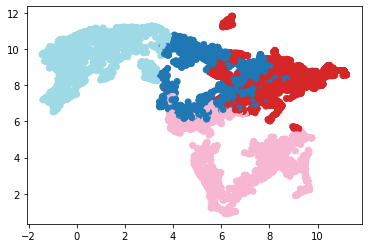

In [63]:
plt.figure()
plt.scatter(umap_x[:,0], umap_x[:,1], c=kmeans.labels_, cmap=plt.cm.tab20)
plt.show()

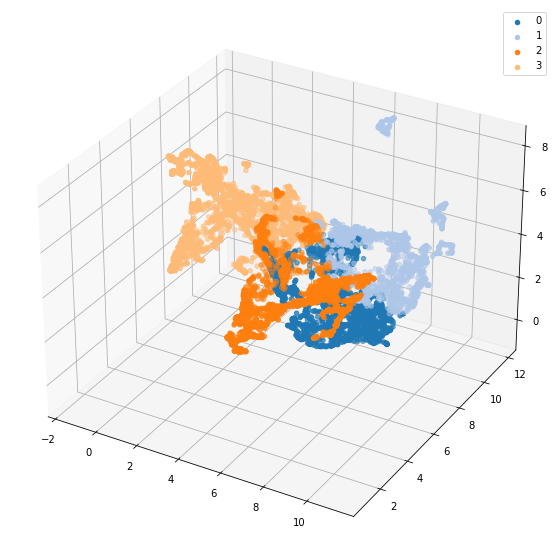

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = [plt.cm.tab20(0), plt.cm.tab20(1), plt.cm.tab20(2), plt.cm.tab20(3), plt.cm.tab20(4), plt.cm.tab20(5), plt.cm.tab20(6), plt.cm.tab20(7), plt.cm.tab20(7)]

for k in range(k_optimal):
    mask = kmeans.labels_ == k
    ax.scatter(umap_x[mask][:,0], umap_x[mask][:,1], umap_x[mask][:,2], color=colors[k], label=str(k))
    
plt.legend()
plt.show()

In [66]:
values, counts = np.unique(kmeans.labels_, return_counts=True)

In [67]:
values

array([0, 1, 2, 3])

In [68]:
counts

array([2297, 1768, 2048, 2837], dtype=int64)

In [69]:
df.groupby(by=['label']).aggregate({'mean', 'std'}).T

label                                            0             1            2  \
BALANCE                          std    242.263598   4235.586482  2604.227476   
                                 mean   115.844738   5351.546106  4243.674579   
BALANCE_FREQUENCY                std      0.192930      0.155542     0.089846   
                                 mean     0.370455      0.948727     0.966930   
PURCHASES                        std    479.872648   8459.048271   578.633200   
                                 mean   332.733581  27085.309200   322.114972   
ONEOFF_PURCHASES                 std    445.260879   9530.796328   477.437196   
                                 mean   203.460619  21002.018800   209.166967   
INSTALLMENTS_PURCHASES           std    243.165043   5776.135354   274.072202   
                                 mean   129.502506   6083.290400   113.041452   
CASH_ADVANCE                     std    823.836034   4791.367812  2032.852771   
                                 mean   329.617555   1488.363253  3467.357514   
PURCHASES_FREQUENCY              std      0.248862      0.233833     0.307423   
                                 mean     0.261745      0.892667     0.221461   
ONEOFF_PURCHASES_FREQUENCY       std      0.113573      0.290160     0.175070   
                                 mean     0.071546      0.808667     0.098857   
PURCHASES_INSTALLMENTS_FREQUENCY std      0.251606      0.370814     0.261131   
                                 mean     0.181880      0.708667     0.135070   
CASH_ADVANCE_FREQUENCY           std      0.075282      0.162660     0.213117   
                                 mean     0.038034      0.056667     0.449549   
CASH_ADVANCE_TRX                 std      1.995148      7.799573     7.006091   
                                 mean     0.775715      2.400000    11.276654   
PURCHASES_TRX                    std      4.473099     89.027018     8.456704   
                                 mean     4.087394    123.320000     4.723346   
CREDIT_LIMIT                     std   3185.590632   5626.425745  3540.357651   
                                 mean  3738.468248  16360.000000  6956.529913   
PAYMENTS                         std   2350.831775   9708.374234  2051.973028   
                                 mean  1101.893240  27159.043527  2285.691116   
MINIMUM_PAYMENTS                 std    195.673658   4916.589206  1375.343062   
                                 mean   180.367275   3201.825604  1475.616041   
PRC_FULL_PAYMENT                 std      0.348897      0.410151     0.083895   
                                 mean     0.229818      0.490758     0.026233   
TENURE                           std      1.511650      0.400000     1.526386   
                                 mean    11.361176     11.920000    11.335478   
umap_label                       std      0.450758      0.000000     1.122579   
                                 mean     2.212684      0.000000     2.487132   

label                                            3            4             5  \
BALANCE                          std   3295.484640  3171.662437   2352.569891   
                                 mean  3603.334889  5366.054218   4076.248041   
BALANCE_FREQUENCY                std      0.058434     0.123036      0.050893   
                                 mean     0.988518     0.956953      0.987315   
PURCHASES                        std   2875.594211  1469.884924   1482.956273   
                                 mean  6269.511315  1061.078703    885.787674   
ONEOFF_PURCHASES                 std   2857.570935  1071.442668    406.031264   
                                 mean  3646.296822   648.498216    122.381628   
INSTALLMENTS_PURCHASES           std   2147.255512   678.706482   1460.658256   
                                 mean  2624.858329   412.580486    763.406047   
CASH_ADVANCE                     std   1438.213123  5703.932153   1963.681344   
                              

In [70]:
df.groupby(by=['umap_label']).aggregate({'mean', 'std'}).T

umap_label                                       0            1            2  \
BALANCE                          std   2306.600932  1015.427381   804.950745   
                                 mean  2091.856235   771.712663   429.547073   
BALANCE_FREQUENCY                std      0.072309     0.050469     0.312231   
                                 mean     0.976503     0.985636     0.642108   
PURCHASES                        std   3560.924622   703.551907   498.437398   
                                 mean  2757.587466   763.406844   449.094663   
ONEOFF_PURCHASES                 std   2868.713180   257.009531   459.492076   
                                 mean  1852.165760   117.497590   267.385552   
INSTALLMENTS_PURCHASES           std   1498.162145   639.765205   305.076428   
                                 mean   905.745141   646.356414   182.202007   
CASH_ADVANCE                     std   1799.478391   514.531307   203.810369   
                                 mean   887.251557   157.126236    35.755766   
PURCHASES_FREQUENCY              std      0.194798     0.236411     0.273022   
                                 mean     0.857317     0.827802     0.364768   
ONEOFF_PURCHASES_FREQUENCY       std      0.321638     0.099594     0.131743   
                                 mean     0.591432     0.059989     0.102031   
PURCHASES_INSTALLMENTS_FREQUENCY std      0.384359     0.257117     0.298346   
                                 mean     0.562961     0.779181     0.252015   
CASH_ADVANCE_FREQUENCY           std      0.203413     0.066128     0.030266   
                                 mean     0.131392     0.028858     0.007909   
CASH_ADVANCE_TRX                 std      6.275697     1.541460     0.511101   
                                 mean     3.246408     0.555430     0.121582   
PURCHASES_TRX                    std     37.597196    12.407697     5.521605   
                                 mean    37.948193    16.223982     5.762207   
CREDIT_LIMIT                     std   4066.996713  2826.732321  3139.266613   
                                 mean  6039.868999  3196.012443  3943.275307   
PAYMENTS                         std   3866.266272   883.560880  1092.061953   
                                 mean  2965.701028   905.468717   802.758187   
MINIMUM_PAYMENTS                 std   1395.903233  4727.614231   652.099325   
                                 mean   900.418669  1381.820075   321.983251   
PRC_FULL_PAYMENT                 std      0.330116     0.337466     0.323401   
                                 mean     0.196358     0.228405     0.195977   
TENURE                           std      1.070720     1.292656     1.308560   
                                 mean    11.706574    11.572964    11.520508   
label                            std      2.288916     0.662627     3.229666   
                                 mean     6.248585     6.806561     3.309570   

umap_label                                       3  
BALANCE                          std   2433.413252  
                                 mean  2450.812669  
BALANCE_FREQUENCY                std      0.212604  
                                 mean     0.899156  
PURCHASES                        std    377.687243  
                                 mean   132.201509  
ONEOFF_PURCHASES                 std    310.291699  
                                 mean   103.118918  
INSTALLMENTS_PURCHASES           std    157.728232  
                                 mean    29.133232  
CASH_ADVANCE                     std   2895.769376  
                                 mean  2245.982600  
PURCHASES_FREQUENCY              std      0.154272  
                                 mean     0.073592  
ONEOFF_PURCHASES_FREQUENCY       std      0.110873  
                                 mean     0.048804  
PURCHASES_INSTALLMENTS_FREQUENCY std      0.104026  
                                 mean     0.026392  
CASH_ADVANCE_FREQUENCY          

In [70]:
df[df.columns[0:15]]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,312.343947
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628


In [11]:
list_features = features[0:15]
X = df[list_features].values

In [13]:
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0, init='random')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [14]:
k_optimal = calculate_optimal_k(inertias)

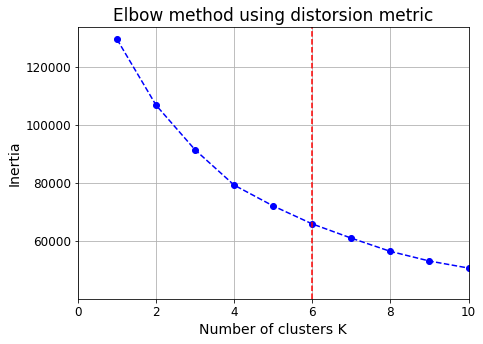

In [15]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 15), inertias, 'bo--')
plt.axvline(x=k_optimal, linestyle='dashed', c='red')
plt.title('Elbow method using distorsion metric', fontsize=17)
plt.xlabel('Number of clusters K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 10])
plt.grid()
plt.show()

In [16]:
kmeans = KMeans(n_clusters=k_optimal, random_state=0, init='random')
kmeans.fit(X)

KMeans(init='random', n_clusters=6, random_state=0)

In [17]:
# number of users on each clusters
values, counts = np.unique(kmeans.labels_, return_counts=True)

for value, count in zip(values, counts):
    print(value, count)

0 87
1 1331
2 2879
3 2256
4 893
5 1190


In [18]:
# centroids
for i, centroid in enumerate(kmeans.cluster_centers_):
    print(i, centroid.round(2))

0 [ 1.39  0.39  6.77  5.95  5.08  0.03  1.08  1.86  1.04 -0.26 -0.05  4.56
  2.16  4.71  1.05]
1 [ 0.13  0.4   0.89  0.85  0.54 -0.3   1.06  1.8   0.52 -0.39 -0.31  1.14
  0.66  0.36 -0.02]
2 [-0.02  0.36 -0.36 -0.24 -0.42 -0.07 -0.87 -0.36 -0.81  0.16 -0.01 -0.49
 -0.34 -0.27 -0.03]
3 [-0.39  0.3  -0.08 -0.25  0.27 -0.36  0.93 -0.38  1.1  -0.46 -0.36  0.1
 -0.33 -0.26 -0.05]
4 [ 1.63  0.35 -0.22 -0.16 -0.22  1.98 -0.47 -0.2  -0.42  1.9   1.88 -0.26
  1.    0.8   0.53]
5 [-0.69 -2.19 -0.31 -0.23 -0.31 -0.3  -0.56 -0.41 -0.48 -0.49 -0.36 -0.43
 -0.2  -0.19 -0.29]


In [19]:
# scatter average distance to each cluster
for i in range(k_optimal):
    center = kmeans.cluster_centers_[i]
    dots = X[kmeans.labels_ == i]
    n_dots, _ = dots.shape
    centers = np.repeat(center.reshape(1, 15), n_dots, axis=0)
    
    distances2 = np.power(dots - centers, 2).sum(axis=1)
    distances = np.power(distances2, 0.5)
    scatter = distances.mean()
    print(i, scatter)

0 9.167784273354057
1 3.010006459752218
2 1.689553132569358
3 1.695683558478004
4 3.7937070973911147
5 1.7110865759470728


In [21]:
df['label'] = kmeans.labels_

In [22]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,label
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,2
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,4
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,1
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12,2
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12,3


In [23]:
df.to_csv('newdata.csv', sep=',', index=False)

In [ ]:
df.boxplot(column=['SOP', 'LOR', 'CGPA'])

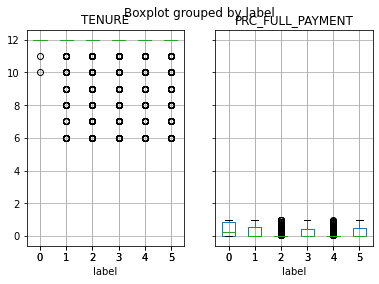

In [28]:
df.boxplot(column=['TENURE', 'PRC_FULL_PAYMENT'], by='label')
plt.show()

<AxesSubplot:xlabel='TENURE', ylabel='PRC_FULL_PAYMENT'>

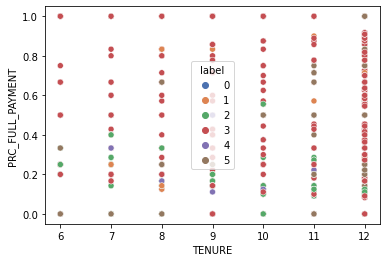

In [30]:
sns.scatterplot(data=df, x="TENURE", y="PRC_FULL_PAYMENT", hue="label", palette="deep")

In [39]:
df.groupby(by='label').agg({'TENURE': ['mean', 'std'], 'PRC_FULL_PAYMENT': ['mean', 'std']})

TENURE           PRC_FULL_PAYMENT          
            mean       std             mean       std
label                                                
0      11.965517  0.238614         0.390184  0.413534
1      11.828700  0.815703         0.271017  0.373073
2      11.494616  1.349808         0.028396  0.089076
3      11.492908  1.388564         0.243903  0.338293
4      11.427772  1.419985         0.039606  0.112653
5      11.428571  1.419979         0.263624  0.359223

In [33]:
X.mean(axis=0)

array([ 0.00000000e+00, -3.42271628e-16,  1.15187567e-17, -3.29107335e-17,
       -2.79741235e-17, -4.27839535e-17,  6.58214670e-18, -3.29107335e-18,
        8.22768337e-18,  2.46830501e-17,  2.71513551e-17, -1.15187567e-17,
        1.11896494e-16, -2.63285868e-17, -4.44294902e-17])

In [34]:
X.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# D. K-mean clusterin

In [43]:
np.where(np.abs(corrs) < 0.2)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
       dtype=int64),
 array([ 2,  3,  4,  6,  7,  8, 11, 16,  2,  3,  4,  5,  7,  8,  9, 10, 11,
        12, 13, 14, 15, 16,  0,  1,  5,  9, 10, 14, 15, 16,  0,  1,  5,  8,
         9, 10, 14, 15, 16,  0,  1,  5,  9, 10, 14, 15, 16,  1,  2,  3,  4

In [44]:
fea

0.17608308856118937

In [45]:
print(features[0], features[2])

BALANCE PURCHASES
